In [26]:
import os
import matplotlib.pyplot as plt

# Set the Spark version
spark_version = 'spark-3.4.0'

# Install Spark and Java
!apt-get update -qq
!apt-get install openjdk-11-jdk-headless -qq > /dev/null

# Download and extract Spark
!wget -q https://archive.apache.org/dist/spark/spark-3.4.0/spark-3.4.0-bin-hadoop3.tgz
!tar xf spark-3.4.0-bin-hadoop3.tgz

# Install findspark
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.0-bin-hadoop3"

# Start a SparkSession
import findspark
findspark.init()

# Import PySpark and related functions
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

# Initialize the SparkSession
spark = SparkSession.builder \
    .appName("SparkApplication") \
    .master("local[*]") \
    .getOrCreate()

# Print the Spark version to verify
print("Spark version:", spark.version)

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Spark version: 3.4.0


In [27]:
# Import packages
from pyspark.sql import SparkSession
import time

# Create a SparkSession
spark = SparkSession.builder.appName("SparkSQL").config("spark.driver.memory", "2g").getOrCreate()

In [28]:
# Load Housing Sales Data
from pyspark import SparkFiles
url = "https://2u-data-curriculum-team.s3.amazonaws.com/dataviz-classroom/v1.2/22-big-data/home_sales_revised.csv"
spark.sparkContext.addFile(url)
# Inspect the data
df_sales = spark.read.csv(SparkFiles.get("home_sales_revised.csv"), sep=",", header=True)
df_sales.show()


+--------------------+----------+----------+------+--------+---------+-----------+--------+------+----------+----+
|                  id|      date|date_built| price|bedrooms|bathrooms|sqft_living|sqft_lot|floors|waterfront|view|
+--------------------+----------+----------+------+--------+---------+-----------+--------+------+----------+----+
|f8a53099-ba1c-47d...|2022-04-08|      2016|936923|       4|        3|       3167|   11733|     2|         1|  76|
|7530a2d8-1ae3-451...|2021-06-13|      2013|379628|       2|        2|       2235|   14384|     1|         0|  23|
|43de979c-0bf0-4c9...|2019-04-12|      2014|417866|       2|        2|       2127|   10575|     2|         0|   0|
|b672c137-b88c-48b...|2019-10-16|      2016|239895|       2|        2|       1631|   11149|     2|         0|   0|
|e0726d4d-d595-407...|2022-01-08|      2017|424418|       3|        2|       2249|   13878|     2|         0|   4|
|5aa00529-0533-46b...|2019-01-30|      2017|218712|       2|        3|       196

In [29]:
# Add calculated and reformatted columns for analysis
df_sales = df_sales \
    .withColumn("year", F.year(F.to_date(F.col("date"), "yyyy-MM-dd"))) \
    .withColumn("price", F.col("price").cast("float")) \
    .withColumn("bedrooms", F.col("bedrooms").cast("int")) \
    .withColumn("bathrooms", F.col("bathrooms").cast("int")) \
    .withColumn("sqft_living", F.col("sqft_living").cast("int")) \
    .withColumn("date_built", F.col("date_built").cast("int"))

In [30]:
# Register as a SQL temporary view
df_sales.createOrReplaceTempView("HomeSales")

In [31]:
# Average Price of 4-Bedroom Houses Sold Per Year
query_avg_price_4_bedrooms = """
SELECT year, ROUND(AVG(price), 2) AS avg_price
FROM HomeSales
WHERE bedrooms = 4
GROUP BY year
ORDER BY year
"""
print("Average price of 4-bedroom houses sold per year:")
spark.sql(query_avg_price_4_bedrooms).show()

Average price of 4-bedroom houses sold per year:
+----+---------+
|year|avg_price|
+----+---------+
|2019| 300263.7|
|2020|298353.78|
|2021|301819.44|
|2022|296363.88|
+----+---------+



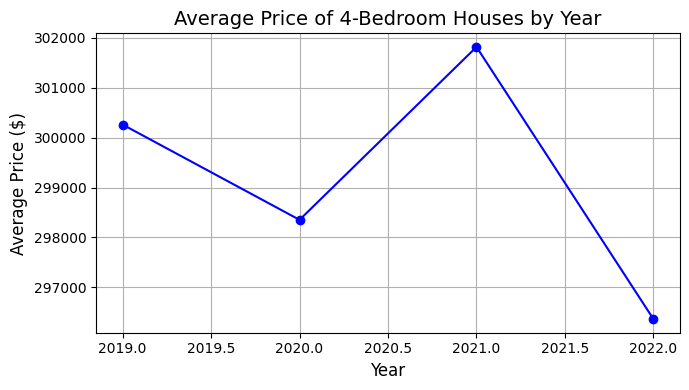

In [32]:
# Query results for Average Price of 4-Bedroom Houses by Year
result_4_bedrooms = spark.sql(query_avg_price_4_bedrooms).toPandas()

# Line Graph for Average Price of 4-Bedroom Houses by Year
plt.figure(figsize=(7, 4))
plt.plot(result_4_bedrooms['year'], result_4_bedrooms['avg_price'], marker='o', color='blue')
plt.title("Average Price of 4-Bedroom Houses by Year", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Average Price ($)", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.savefig("Visualization/avg_price_4_bedrooms.png", dpi=300)
plt.show()

In [33]:
# Average Price by Year Built for Homes with 3 Bedrooms and 3 Bathrooms
query_avg_price_3b_3ba = """
SELECT date_built, ROUND(AVG(price), 2) AS avg_price
FROM HomeSales
WHERE bedrooms = 3 AND bathrooms = 3
GROUP BY date_built
ORDER BY date_built
"""
print("Average price by year built for 3-bedroom, 3-bathroom homes:")
spark.sql(query_avg_price_3b_3ba).show()

Average price by year built for 3-bedroom, 3-bathroom homes:
+----------+---------+
|date_built|avg_price|
+----------+---------+
|      2010|292859.62|
|      2011|291117.47|
|      2012|293683.19|
|      2013|295962.27|
|      2014|290852.27|
|      2015| 288770.3|
|      2016|290555.07|
|      2017|292676.79|
+----------+---------+



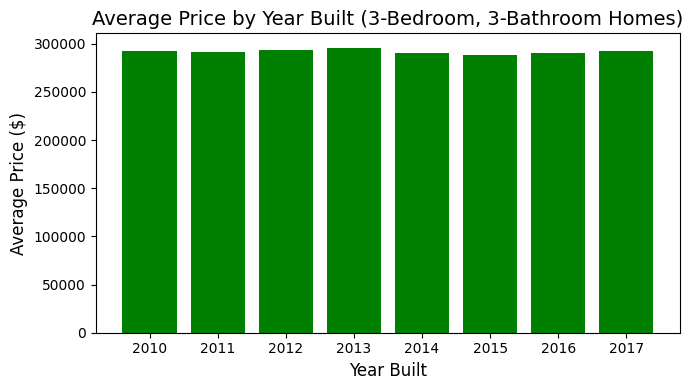

In [34]:
# Query results for Average Price by Year Built for 3-Bedroom, 3-Bathroom Homes
result_3b_3ba = spark.sql(query_avg_price_3b_3ba).toPandas()

# Bar Chart for Average Price by Year Built for 3-Bedroom, 3-Bathroom Homes
plt.figure(figsize=(7, 4))
plt.bar(result_3b_3ba['date_built'], result_3b_3ba['avg_price'], color='green')
plt.title("Average Price by Year Built (3-Bedroom, 3-Bathroom Homes)", fontsize=14)
plt.xlabel("Year Built", fontsize=12)
plt.ylabel("Average Price ($)", fontsize=12)
plt.tight_layout()
plt.savefig("Visualization/avg_price_3b_3ba.png", dpi=300)
plt.show()

In [35]:
# Average Price for Homes with Specific Criteria
query_avg_price_criteria = """
SELECT date_built, ROUND(AVG(price), 2) AS avg_price
FROM HomeSales
WHERE bedrooms = 3 AND bathrooms = 3 AND floors = 2 AND sqft_living >= 2000
GROUP BY date_built
ORDER BY date_built
"""
print("Average price for 3-bedroom, 3-bathroom, 2-floor homes with >= 2000 sqft:")
spark.sql(query_avg_price_criteria).show()

Average price for 3-bedroom, 3-bathroom, 2-floor homes with >= 2000 sqft:
+----------+---------+
|date_built|avg_price|
+----------+---------+
|      2010|285010.22|
|      2011|276553.81|
|      2012|307539.97|
|      2013|303676.79|
|      2014|298264.72|
|      2015|297609.97|
|      2016| 293965.1|
|      2017|280317.58|
+----------+---------+



In [36]:
# Average Price by View Rating (>= $350,000)
start_time = time.time()
query_avg_price_by_view = """
SELECT view, ROUND(AVG(price), 2) AS avg_price
FROM HomeSales
GROUP BY view
HAVING AVG(price) >= 350000
ORDER BY view DESC
"""
print("Average price by view rating (>= $350,000):")
spark.sql(query_avg_price_by_view).show()
print(f"Query runtime: {time.time() - start_time:.2f} seconds")

Average price by view rating (>= $350,000):
+----+----------+
|view| avg_price|
+----+----------+
|  99|1061201.42|
|  98|1053739.33|
|  97|1129040.15|
|  96|1017815.92|
|  95| 1054325.6|
|  94| 1033536.2|
|  93|1026006.06|
|  92| 970402.55|
|  91|1137372.73|
|  90|1062654.16|
|  89|1107839.15|
|  88|1031719.35|
|  87| 1072285.2|
|  86|1070444.25|
|  85|1056336.74|
|  84|1117233.13|
|  83|1033965.93|
|  82| 1063498.0|
|  81|1053472.79|
|  80| 991767.38|
+----+----------+
only showing top 20 rows

Query runtime: 1.30 seconds


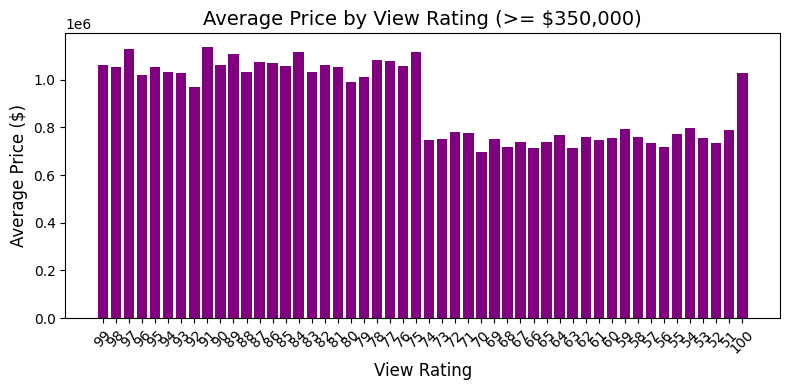

In [37]:
# Query results for Average Price by View Rating (>= $350,000)
result_view_rating = spark.sql(query_avg_price_by_view).toPandas()

# Bar Chart for Average Price by View Rating
plt.figure(figsize=(8, 4))
plt.bar(result_view_rating['view'], result_view_rating['avg_price'], color='purple')
plt.title("Average Price by View Rating (>= $350,000)", fontsize=14)
plt.xlabel("View Rating", fontsize=12)
plt.ylabel("Average Price ($)", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()
plt.savefig("Visualization/avg_price_by_view.png", dpi=300)
plt.show()

In [38]:
# Save Data Partitioned by `date_built`
df_sales.write.partitionBy("date_built").mode("overwrite").parquet("date_built")

In [39]:
# Load and Analyze Parquet Data
parquet_data = spark.read.parquet("date_built")
parquet_data.createOrReplaceTempView("ParquetSales")
start_time = time.time()
spark.sql(query_avg_price_by_view).show()
print(f"Parquet query runtime: {time.time() - start_time:.2f} seconds")

+----+----------+
|view| avg_price|
+----+----------+
|  99|1061201.42|
|  98|1053739.33|
|  97|1129040.15|
|  96|1017815.92|
|  95| 1054325.6|
|  94| 1033536.2|
|  93|1026006.06|
|  92| 970402.55|
|  91|1137372.73|
|  90|1062654.16|
|  89|1107839.15|
|  88|1031719.35|
|  87| 1072285.2|
|  86|1070444.25|
|  85|1056336.74|
|  84|1117233.13|
|  83|1033965.93|
|  82| 1063498.0|
|  81|1053472.79|
|  80| 991767.38|
+----+----------+
only showing top 20 rows

Parquet query runtime: 0.41 seconds


In [40]:
# Cache the the temporary table home_sales.
spark.sql("cache table HomeSales")

DataFrame[]

In [41]:
# Check if the table is cached.
spark.catalog.isCached('HomeSales')

True

In [42]:
# Run cached query to calculate average price by view rating (>= $350,000) and measure runtime
start_time = time.time()
df_result = spark.sql("""
SELECT view, ROUND(AVG(price), 2) AS avg_price
FROM HomeSales
GROUP BY view
HAVING AVG(price) >= 350000
ORDER BY view DESC
""")
df_result.show()
print(f"Runtime: {time.time() - start_time:.2f} seconds")

+----+----------+
|view| avg_price|
+----+----------+
|  99|1061201.42|
|  98|1053739.33|
|  97|1129040.15|
|  96|1017815.92|
|  95| 1054325.6|
|  94| 1033536.2|
|  93|1026006.06|
|  92| 970402.55|
|  91|1137372.73|
|  90|1062654.16|
|  89|1107839.15|
|  88|1031719.35|
|  87| 1072285.2|
|  86|1070444.25|
|  85|1056336.74|
|  84|1117233.13|
|  83|1033965.93|
|  82| 1063498.0|
|  81|1053472.79|
|  80| 991767.38|
+----+----------+
only showing top 20 rows

Runtime: 0.31 seconds


In [43]:
# Partition by the "date_built" field on the formatted parquet home sales data
df_sales.write.partitionBy("date_built").mode("overwrite").parquet("date_built")

In [44]:
# Read the parquet formatted data in our new parquet formatted data
p_df_sales=spark.read.parquet("date_built")

In [45]:
# Create a temporary table for the parquet data.
p_df_sales.createOrReplaceTempView('p_sales_p')

In [46]:
# Run query on Parquet data to calculate average price by view rating (>= $350,000) and measure runtime
start_time = time.time()
spark.sql("""
SELECT view, ROUND(AVG(price), 2) AS avg_price
FROM p_sales_p
GROUP BY view
HAVING AVG(price) >= 350000
ORDER BY view DESC
""").show()
print(f"Runtime: {time.time() - start_time:.2f} seconds")

+----+----------+
|view| avg_price|
+----+----------+
|  99|1061201.42|
|  98|1053739.33|
|  97|1129040.15|
|  96|1017815.92|
|  95| 1054325.6|
|  94| 1033536.2|
|  93|1026006.06|
|  92| 970402.55|
|  91|1137372.73|
|  90|1062654.16|
|  89|1107839.15|
|  88|1031719.35|
|  87| 1072285.2|
|  86|1070444.25|
|  85|1056336.74|
|  84|1117233.13|
|  83|1033965.93|
|  82| 1063498.0|
|  81|1053472.79|
|  80| 991767.38|
+----+----------+
only showing top 20 rows

Runtime: 0.38 seconds


In [47]:
# Uncache the home_sales temporary table.
spark.sql("uncache table HomeSales")

DataFrame[]

In [48]:
# Check if the home_sales is no longer cached

spark.catalog.isCached("HomeSales")

False

In [49]:
# Close the SparkSession
spark.stop()